In [1]:
# Script for training a denoiser on KappaTNG
import os

os.environ['XLA_FLAGS']='--xla_gpu_cuda_data_dir=/gpfslocalsys/cuda/10.1'

from absl import app
from absl import flags

import tensorflow as tf
import tensorflow_datasets as tfds

import jax.numpy as jnp

from jax_lensing.inversion import ks93, ks93inv
from jax_lensing.utils import load_dataset

from astropy.io import fits

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
batch_size = 32
train_split = "80%"
noise_dist_std = 0.2

In [4]:
train = load_dataset(batch_size, noise_dist_std, train_split)
print('done')
x = next(train)["x"]

done


In [5]:
# Let's prepare some test data
def load_dataset():
  def pre_process(im):
    """ Pre-processing function preparing data for denoising task
    """
    # Cutout a portion of the map
    x = tf.expand_dims(im['map'],-1)
    return x
  ds = tfds.load('kappatng', split='train[:-10%]', shuffle_files=False)
  ds = ds.map(pre_process)
  return iter(tfds.as_numpy(ds))

In [6]:
# Instantiate dataset and sample map
dset = load_dataset()
ref_map = next(dset)
ref_map = next(dset)
ref_map = next(dset)

In [7]:
mask = fits.getdata('../data/COSMOS/cosmos_full_mask_0.29arcmin.fits').astype('float32')

(1024, 1024)

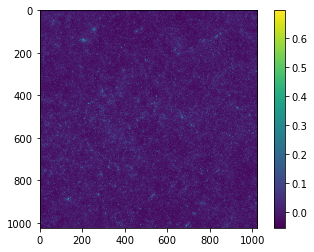

In [8]:
# This is our input map
imshow(ref_map[:,:,0]); colorbar();
ref_map[:,:,0].shape

In [9]:
# We turn it into shear
e1,e2 = ks93inv(ref_map[...,0], jnp.zeros_like(ref_map[...,0]))
# And we extract a patch that put the big cluster right at the edge

k = ref_map[0:512,0:512,0]
e1 = e1[0:512,0:512]
e2 = e2[0:512,0:512]

(-0.5, 511.5, 511.5, -0.5)

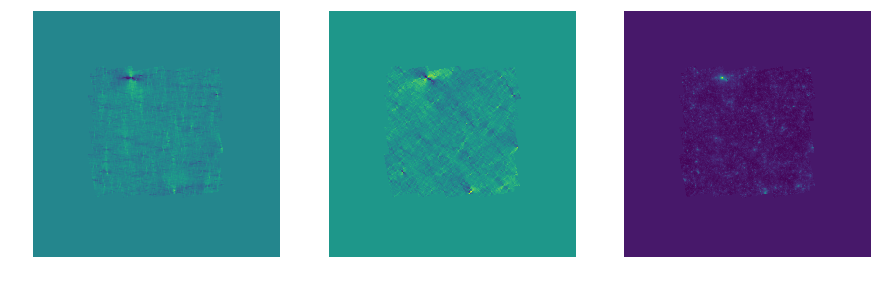

In [10]:
figure(figsize=[15,5])
subplot(131)
imshow(e1*mask)
axis('off')
subplot(132)
imshow(e2*mask)
axis('off')
subplot(133)
imshow(k*mask)
axis('off')

**Compare with True COSMOS shear noise**

0.14842281


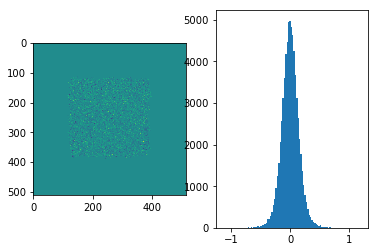

In [11]:
cosmos_e1 = fits.getdata('../data/COSMOS/cosmos_full_e1_0.29arcmin.fits').astype('float32')
subplot(121)
imshow(cosmos_e1)
subplot(122)
m = cosmos_e1 == 0
hist(cosmos_e1[~m], 100);
print(jnp.std(cosmos_e1[~m]))

In [12]:
sigma_noise = 0.148 # We have a noise of 0.148

In [13]:
# And, last but not least, we can also include reduced shear
g1 = e1 / (1 - k)
g2 = e2 / (1 - k)

0.14842281


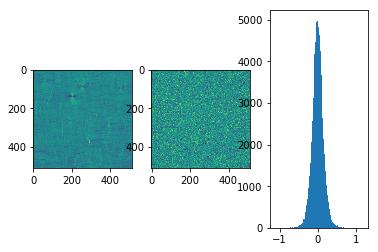

In [14]:
subplot(131)
imshow(e1)
subplot(132)
imshow(g1 + sigma_noise*randn(512,512))
subplot(133)
mock_cosmo_e1 = mask*(g1 + sigma_noise*randn(512,512))
m = cosmos_e1 == 0
hist(cosmos_e1[~m], 100);
print(jnp.std(cosmos_e1[~m]))

In [15]:
# We can save for testing this map with added noise
fits.writeto('../data/ktng/ktng_cosmos_kappa.fits',k)
fits.writeto('../data/ktng/ktng_cosmos_e.fits',
              np.stack([mask*(g1 + sigma_noise*randn(512,512)),
                        mask*(g2 + sigma_noise*randn(512,512))],axis=-1))